We consider a pure exchange economy with $M$ agents and $n$ commodities.
Each agent $i$ has an endowment $e_i \in {\bf{R}}_+^n$ and a utility 
function $U_i(r_i)$, where $U_i: {\bf{R}}_+^n \to {\bf{R}}$ is a concave nondecreasing. These primitives define the exchange economy $\mathcal{E}=\left( (U_i, e_i)_{i \in [M]}\right)$. Denote the total endowment by $E = \sum_{i=1}^M e_i$.


**Walrasian equilibrium** for exchange economy $\mathcal{E}$ is a vector $\left( \nu, (x_i)_{i \in [M]}\right)$, such that 
* every agent's consumption  $x_i\in {\bf{R}}^n$ maximizes her utility given prices $\nu \in {\bf{R}}_+^n$
$$
\begin{array}{ll}
\mbox{maximize} & U_i(x_i)  \\
\mbox{subject to} & \nu^T x_i \leq \nu^T e_i \\
& x_i \geq  0,
\end{array}
$$
* markets clear $\sum_{i=1}^M x_i \leq \sum_{i=1}^M e_i=E$.

The goal of this notebook is to see the performance of OSBDO when applied to the action directed Walrasian Equilibrium (over primal variables $x_1, \ldots, x_M$) and price directed Walrasian Equilibrium (over dual variable $\nu$). This corresponds to the primal formulation of the problem, given by
$$
\begin{array}{ll}
\mbox{minimize} & \sum_{i=1}^M -U_i(x_i)  \\
\mbox{subject to} & \sum_{i=1}^M x_i = E \\
& x_i  \geq 0, \quad i=1,\ldots, M,
\end{array}
$$
and negated dual formulation of the problem, given by  
$$
\begin{array}{ll}
\mbox{minimize} & \sum_{i=1}^M \underset{x_i\geq 0}{\max} \left(
 U_i(x_i) - \nu_i^Tx_i 
\right ) + \nu_1^T E   \\
\mbox{subject to} & \nu_1=\cdots=\nu_M.
\end{array}
$$


In [1]:
import cvxpy as cp
import numpy as np
import osbdo as ob
import random

from scipy import stats
import time
from scipy import stats

In [2]:
import matplotlib.pyplot as plt

In [3]:
import random, time

np.random.seed(1001)
random.seed(1001)

In [4]:
def get_rel_diff(a,b):
    return np.linalg.norm(a-b) / min(np.linalg.norm(a), np.linalg.norm(b)) 

In [5]:
def check_subgrads(agent, ntimes):
    l, u = agent.lwb, agent.upb
    n = agent.dim
    for _ in range(ntimes):
        v = l + np.multiply(np.random.rand(n), u-l)
        point = agent.query(v=v)
        linear = lambda x: point.f + point.q @ (x - point.x)
        for _ in range(10):
            test = l + np.multiply(np.random.rand(n), u-l)
            a = linear(test)
            b = agent.query(v=test).f + 10**(-6)
            assert a <= b, print(a, b, b-a)
    print("passed")

# Create instance of the problem

In [6]:
M = 50

params, R = ob.ra_params(num_resources=M, num_agents=M, num_participants=M)

In [7]:
E = R
n = params[0]['dimension']

In [8]:
for j in range(n):
    count = 0
    for i in range(M):
        A = params[i]["A_list"][0]
        if A[0,j] > 0:
            count += 1
    assert count > 0

# Centralized solution

In [9]:
dim = params[0]['dimension']
z = cp.Variable(len(params)*dim)
num_agents = len(params)
constraints = []
f = 0
xi_list = []
start = time.time()
for i in range(num_agents):
    xi = z[(i*dim):((i+1)*dim)]
    X = cp.Variable((len(params[i]['A_list']), dim))
    for j in range(len(params[i]['A_list'])):
        f += -cp.geo_mean(params[i]['A_list'][j] @ X[j].T + params[i]['b_list'][j])
    constraints += [cp.sum(X,axis=0) <= xi, \
                    X>=0, \
                    xi<=params[i]['upper_bound'], 
                    xi>=params[i]['lower_bound']]
    xi_list.append(xi)
constraints += [sum(xi_list)==R]
prob_cvx = cp.Problem(cp.Minimize(f), constraints)
prob_cvx.solve(solver='ECOS')
print(f"elapsed time =  {time.time()-start}")

h_cvx, x_cvx = f.value, z.value
nu_cvx = constraints[-1].dual_value
print(f"{h_cvx = }")

elapsed time =  1.5994091033935547
h_cvx = -401.83914918723735


### Initial upper bound on $\nu$
$$
\nu^\star_j \leq \nu_{\max,j} ~=~ \min_{i:{A_{i, \cdot j}}\neq 0 } \quad \left [ (1/m) \mbox{geomean}(A_i E + b_i) ~ A_i^T b_i^{-1} \right ]
$$

In [10]:
nu_upb = np.inf * np.ones(n)
m = params[0]["A_list"][0].shape[0]

for i  in  range(M):
    A = params[i]["A_list"][0]
    b = params[i]["b_list"][0]
    assert (A>=0).all() and (b>=0).all()
    Ui = stats.mstats.gmean(A@E + b)
    grad_i = (Ui/m) * A.T @ b**(-1)
    
    for j in range(n):
        if A[0,j] > 0:
            nu_upb[j] = min(nu_upb[j], grad_i[j])

In [11]:
nu_cvx.min(), nu_cvx.max(), nu_upb.min(), nu_upb.max()

(0.6712384168244405, 0.9072204434938136, 9.224530016791945, 21.609593105630275)

In [12]:
assert (nu_cvx <= nu_upb + 10**(-8) ).all(), print("wrong bound on nu")

# Action directed Walrasian equilibrium
$$
\begin{array}{ll}
\mbox{minimize} & \sum_{i=1}^M -U_i(x_i)  \\
\mbox{subject to} & \sum_{i=1}^M x_i = E \\
& x_i  \geq 0, \quad i=1,\ldots, M,
\end{array}
$$
where $U_i(x_i)= \left (\prod_{k=1}^m (A_{i,k}x_{i} + b_{i,k})\right)^{1/m}$.

## OSBDO oracle-structured form 
We can solve the problem using OSBDO, by taking the agent function
$$
f_i(x_i) = -U_i(x_i),$$
and the structured objective function $g$,
$$
g(x) = \left\{ \begin{array}{ll} 0 &
x_1 + \cdots + x_M = E, \quad x_i \geq 0, \quad i=1, \ldots, M\\
\infty & \mbox{otherwise}.
\end{array} \right.
$$

In [13]:
rel_gap = 0.01

# OSBDO solution

In [14]:
agents = ob.ra_agents(params=params)

domain = [sum([agents[i].x for i in range(len(agents))])==R]
g = ob.Coupling(agents = agents, function = cp.Constant(0), domain = domain)

prob = ob.Problem(agents = agents, g = g)

In [15]:
start = time.time()
x_agent, x_global = prob.solve(rel_gap=rel_gap, abs_gap=10**(-3), max_iter=60)
print(f"elapsed time =  {time.time()-start}")

k=0, rel_gap=28.559203959175875, L=-8495.399164212251, U=-287.40283993930353, L0=-8495.399164212251
k=1, rel_gap=0.43308644362598375, L=-411.87311377662434, U=-287.40283993930353, L0=-411.87311377662434
k=2, rel_gap=0.17673086815801123, L=-409.33505312511437, U=-347.8578358073198, L0=-409.33505312511437
k=3, rel_gap=0.09154754320708462, L=-408.9619200699718, U=-374.6624896139636, L0=-408.9619200699718
k=4, rel_gap=0.05900532537711672, L=-408.766241424627, U=-385.9907326519472, L0=-408.766241424627
k=5, rel_gap=0.04697736812606132, L=-408.63667825535293, U=-390.3013481435169, L0=-408.63667825535293
k=6, rel_gap=0.04200941889745147, L=-408.4552222256562, U=-391.988032754869, L0=-408.4552222256562
k=7, rel_gap=0.04005414873483919, L=-408.3168792264533, U=-392.59194314367693, L0=-408.3168792264533
k=8, rel_gap=0.03920697526336679, L=-408.1632428410418, U=-392.7641485832028, L0=-408.1632428410418
k=9, rel_gap=0.038541536171977184, L=-407.90188222287816, U=-392.7641485832028, L0=-407.9018822

/Users/parshakova.tanya/opt/anaconda3/envs/osbdo/lib/python3.9/site-packages/cvxpy/problems/problem.py:1385: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


k=13, rel_gap=0.03214773340396488, L=-405.3906257224909, U=-392.7641485832028, L0=-405.3906257224909
k=14, rel_gap=0.029088569427799117, L=-405.2971068259953, U=-393.84084020226885, L0=-405.2971068259953
k=15, rel_gap=0.028282113531061904, L=-405.2014980361198, U=-394.0567405618688, L0=-405.2014980361198
k=16, rel_gap=0.027697264592427266, L=-405.0415615875123, U=-394.12536701471817, L0=-405.0415615875123
k=17, rel_gap=0.02377572205577456, L=-403.5824397554349, U=-394.20981672140886, L0=-403.5824397554349
k=18, rel_gap=0.01811145403000921, L=-403.5253672707425, U=-396.3469477466938, L0=-403.5253672707425
k=19, rel_gap=0.01348585536208388, L=-402.76934338108754, U=-397.409930538391, L0=-402.76934338108754
k=20, rel_gap=0.007994362854655365, L=-402.7549204656009, U=-399.5606873484816, L0=-402.7549204656009
rho=10.838227337605082


/var/folders/13/wyn3w3nx7ks002_qzk18rz7h0000gn/T/ipykernel_12869/2063845772.py:2: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  x_agent, x_global = prob.solve(rel_gap=rel_gap, abs_gap=10**(-3), max_iter=60)


rel_gap=0.007994362854655365, L=-402.7549204656009, U=-399.5606873484816
elapsed time =  123.9793930053711


# $L^k, \quad h^\star, \quad U^k$

In [16]:
prob.lower_bnd[-1], h_cvx, prob.upper_bnd[-1]

(-402.7549204656009, -401.83914918723735, -399.5606873484816)

## Plot

i=20, omega_k=0.007994362854655365, omega_true=0.005670084269698869


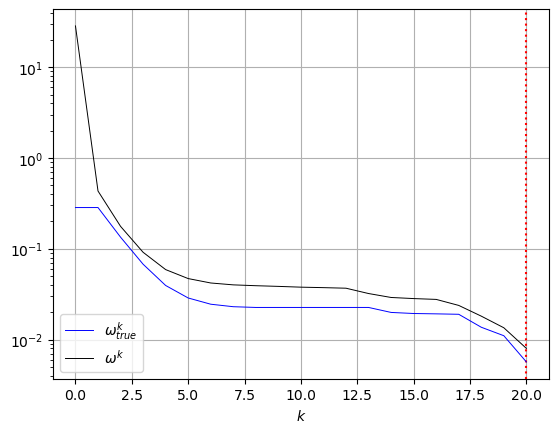

In [17]:
ob.plot_true_rel_gap_uk(lk = prob.lower_bnd, uk = prob.upper_bnd, h_true = h_cvx)

# Price directed Walrasian equilibrium
$$
\begin{array}{ll}
\mbox{minimize} & \sum_{i=1}^M \underset{x_i\geq 0}{\max} \left(
 U_i(x_i) - \nu_i^Tx_i 
\right ) + \nu_1^T E   \\
\mbox{subject to} & \nu_1=\cdots=\nu_M,
\end{array}
$$
where $U_i(x_i)= \left (\prod_{k=1}^m (A_{i,k}x_{i} + b_{i,k})\right)^{1/m}$.

## OSBDO oracle-structured form 

We can solve the problem in the dual variable using OSBDO, by taking the agent function
$$
f_i(\nu_i) = \underset{E \geq x_i\geq 0}{\max} \left(
 U_i(x_i) - \nu_i^Tx_i 
\right ),
$$
and $g$ the indicator function for consensus plus the total price for all  commodities,
$$
g(x) = \left\{ \begin{array}{ll}  \nu_1^T E & \nu_1 = \cdots = \nu_M\\
\infty & \mbox{otherwise}. 
\end{array}\right.
$$
Note that $f_i$ is convex as a pointwise supremum over linear functions in $\nu_i$.

In [18]:
class GeoMeanConj(ob.Agent):
    """
    fi(nu_i)  = \max_{E\geq x_i\geq 0} ( U_i(x_i) - \nu_i^Tx_i )
    """
    def _construct_params(self):
        self.A = self.params['A']
        self.b = self.params['b']
        self.E = self.params['E']
        self.nu_max = self.params['nu_max']

    def query(self, *, v, solver='ECOS'):
        x = cp.Variable((self.dim), nonneg=True)
        f = cp.geo_mean(self.A @ x + self.b) - v @ x
        prob = cp.Problem(cp.Maximize(f), [x <= self.E])
        prob.solve(solver=cp.MOSEK)
        f = f.value
        q = -x.value
        return ob.Point(x=v, q=q, f=f)
    
    def get_init_minorant(self):
        lwb = stats.mstats.gmean(self.b, axis=None) - self.E @ self.nu_max
        self.lwb_const = lwb
        return cp.Constant(lwb)
    
def get_total_obj(agents, xs):
    obj = 0
    for agent in agents:
        obj += stats.mstats.gmean(agent.A @ xs[i] + agent.b, axis=None)
    return -obj

In [19]:
agents = [0]*M
nu_params = []
for i  in  range(M): 
    nu_params += [{ 'dimension':n, 
                    'lower_bound':0, 
                    'upper_bound':None,
                    'nu_max':nu_upb,
                    'E':E,
                    'A':params[i]["A_list"][0],
                    'b':params[i]["b_list"][0]}]
    
    agents[i] = GeoMeanConj(nu_params[i])

In [20]:
domain = [agents[0].x == agent.x for agent in agents[1:]]

g = ob.Coupling(agents = agents, function = agents[0].x @ E, domain = domain)

In [21]:
prob = ob.Problem(agents = agents, g = g)

# OSBDO solution

In [22]:
start = time.time()
x_agent, x_global = prob.solve(rel_gap=rel_gap, abs_gap=10**(-3), max_iter=50, \
                               solver="OSQP")
print(f"elapsed time =  {time.time()-start}")

k=0, rel_gap=inf, L=-286487.68618835206, U=8495.399015392732, L0=-286487.68618835206
k=1, rel_gap=inf, L=-280088.7815561754, U=8495.399015392732, L0=-280088.7815561754
k=2, rel_gap=inf, L=-258430.55726217257, U=3422.5974978393806, L0=-258430.55726217257
k=3, rel_gap=inf, L=-252515.83414154517, U=3422.5974978393806, L0=-252515.83414154517
k=4, rel_gap=10.861566657960843, L=288.54514724176994, U=3422.5974978393806, L0=288.54514724176994
k=5, rel_gap=5.492748072736978, L=288.8971625842197, U=1875.7364955878738, L0=288.8971625842197
k=6, rel_gap=2.8885593836107586, L=290.7992740355492, U=1130.7902457981313, L0=290.7992740355492
k=7, rel_gap=1.5411518259468628, L=294.0262469170307, U=747.1653342295157, L0=294.0262469170307
k=8, rel_gap=0.8922651881642532, L=304.6361823033534, U=576.4524428278947, L0=304.6361823033534
k=9, rel_gap=0.4650023264312015, L=313.715482649138, U=459.59391191847436, L0=313.715482649138
k=10, rel_gap=0.29356536208449385, L=355.29237670516284, U=459.59391191847436, L0

# $L^k, \quad h^\star, \quad U^k$

In [23]:
prob.lower_bnd[-1], -h_cvx, prob.upper_bnd[-1]

(400.00115989888627, 401.83914918723735, 403.689350471482)

i=14, omega_k=0.009220449694515959, omega_true=0.004573942812860847


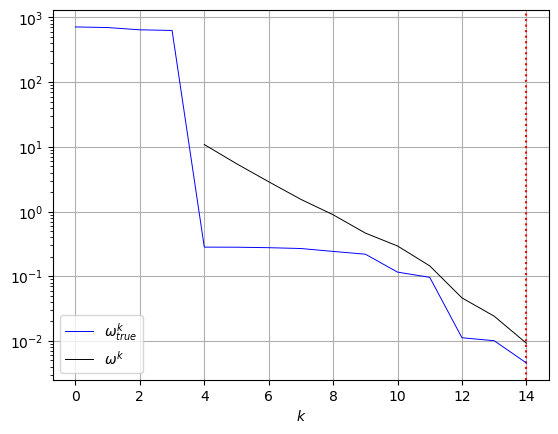

In [24]:
ob.plot_true_rel_gap_uk(lk = -np.array(prob.upper_bnd), uk = -np.array(prob.lower_bnd), h_true = h_cvx)